In [300]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as ss 

import datetime
from pandas_datareader import data,wb
import pandas_profiling
import warnings
warnings.filterwarnings("ignore")

class Data:
    def __init__(self,target,market,start_date,end_date):
        self.stock_data = self._create_data(target,market,start_date,end_date)
        
    def _create_data(self,target,market,start_date,end_date):
        tickers = target+ market
        # Stock data 
        df_stock = self.load_data(tickers,start_date,end_date)
        
        df_stock['stock_return']= df_stock['Close'][target].pct_change().shift(1)
        df_stock['sp500_pct']= df_stock['Open'][market[1]].pct_change().shift(1)
        df_stock['nasdaq_pct']= df_stock['Open'][market[0]].pct_change().shift(1)
        
        return df_stock
            
    def load_data(self,tickers,start_date,end_date):
        return data.get_data_yahoo(tickers,start_date,end_date)[['Open','Close']]
    

        

In [344]:
class Plotting:
    def __init__(self,df,stock_index,market_index,rolling_win):
    
        self.tickers = stock_index+market_index
        self.moving_avg = self._get_moving(df,stock_index,rolling_win)
        self.spy_compare = self._compared_spy(df,stock_index)
        self.corr = self._correlation_matrix(df,self.tickers)
        self.cov = self._covariance_spy(df)
    
    
    def _get_moving(self,df,stock_data,rolling_win):
        
        rolling_mean = df['Close'][stock_data[0]].rolling(rolling_win).mean()
        rolling_std = df['Close'][stock_data[0]].rolling(rolling_win).std()
        upper_band = rolling_mean + 2*rolling_std
        lower_band = rolling_mean- 2 *rolling_std
        
        plt.figure(figsize=(10,5))
        sns.lineplot(x=df.index,y= rolling_mean,label='rolling_mean')
        sns.lineplot(x=df.index,y= upper_band)
        sns.lineplot(x=df.index,y= lower_band)
        sns.lineplot(x=df.index,y= df['Close'][stock_data[0]],label ='Stock Price')
        plt.xticks(rotation=45)
        plt.legend()
        plt.title('Stock price movement with rolling window {}'.format(rolling_win))
        plt.show()
        
    def _correlation_matrix(self,df,tickers):
        fig = plt.figure(figsize=(12, 10))
        sns.heatmap(df['Close'][tickers].corr(), cmap='Reds', annot=True)
        plt.xticks(rotation=45)
        plt.title('Correlation Matrix on overall Price')
        plt.show()
        
        
    def _compared_spy(self,df,stock_data):
        plt.figure(figsize=(10,5))
        # Plot price change
        plt.subplot(1,2,1)
        sns.lineplot(x=df.index,y= df['Close']['SPY'],label ='SPY')
        sns.lineplot(x=df.index,y= df['Close'][stock_data[0]],label ='Stock Price')
        plt.xticks(rotation=45)
        plt.legend()
        plt.title('Price change')
        
        # Plot percentage change
        plt.subplot(1,2,2)
        sns.lineplot(x=df.index,y= df['sp500_pct'],label ='SPY')
        sns.lineplot(x=df.index,y= df['stock_return'],label ='Stock Price')
        plt.xticks(rotation=45)
        plt.legend()
        plt.title('Daily Percentage Change')
        plt.show()
    
    def _covariance_spy(self,df):
        covariance_spy = df[['stock_return','sp500_pct']].dropna().cov()
        print('Covariance with SPY: \n{}'.format(covariance_spy))
        df = df.dropna()
        cor = ss.stats.pearsonr(df['stock_return'],df['sp500_pct'])[0]
        print('Correlation Coefficent is {}'.format(round(cor,3)))
        p_val = ss.stats.pearsonr(df['stock_return'],df['sp500_pct'])[1]
        print('The P-value is {}, which is less than the significant level of 5%'.format(round(p_val,3)))
        
        
        if ((covariance_spy.iloc[0,1]>0) &(p_val <0.05) ) : 
            print('The daily percentage change between targeted stock and SPY are strongly dependent with each other. They tend to move in the same direction')
        elif ((covariance_spy.iloc[0,1]<0)&(p_val <0.05)):
            print('The daily percentage change between targeted stock and SPY are strongly dependent with each other. They tend to move in the opposite direction')
        else: 
            print('The daily percentage change between targeted stock and SPY are not dependent with each other')
        if (np.sqrt((covariance_spy.iloc[0,0])) > np.sqrt((covariance_spy.iloc[0,1]))):
            print('Target stock is more volatile than the market because of its higher standard deviation overall during this period')
        else: 
            print('Target stock is more stable than the market')

        
        


Header of stock data:
Attributes        Open                              Close             \
Symbols           AMZN       NDAQ         SPY        AMZN       NDAQ   
Date                                                                   
2017-01-09  798.000000  68.370003  226.910004  796.919983  67.769997   
2017-01-10  796.599976  67.620003  226.479996  795.900024  67.199997   
2017-01-11  793.659973  67.190002  226.360001  799.020020  67.720001   
2017-01-12  800.309998  67.440002  226.500000  813.640015  67.400002   
2017-01-13  814.320007  67.330002  226.729996  817.140015  67.709999   

Attributes             stock_return sp500_pct nasdaq_pct  
Symbols            SPY                                    
Date                                                      
2017-01-09  226.460007          NaN       NaN        NaN  
2017-01-10  226.460007          NaN       NaN        NaN  
2017-01-11  227.100006    -0.001280 -0.001895  -0.010970  
2017-01-12  226.529999     0.003920 -0.000530  

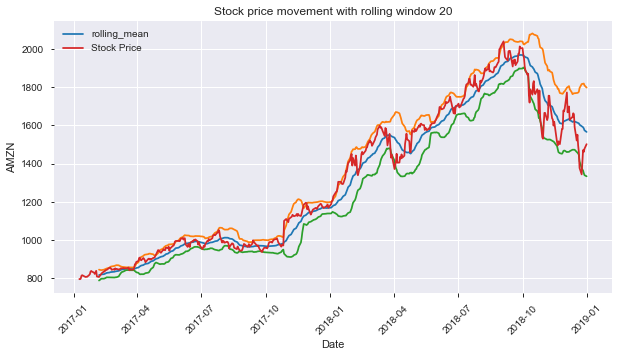

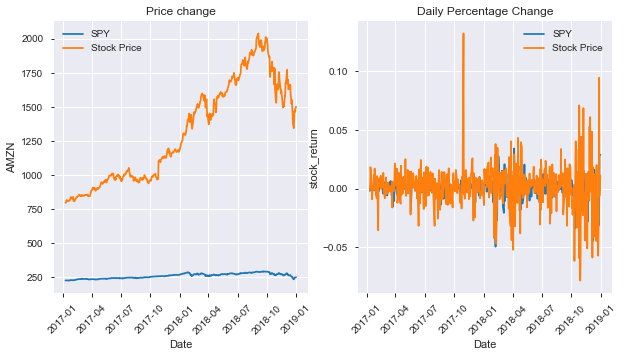

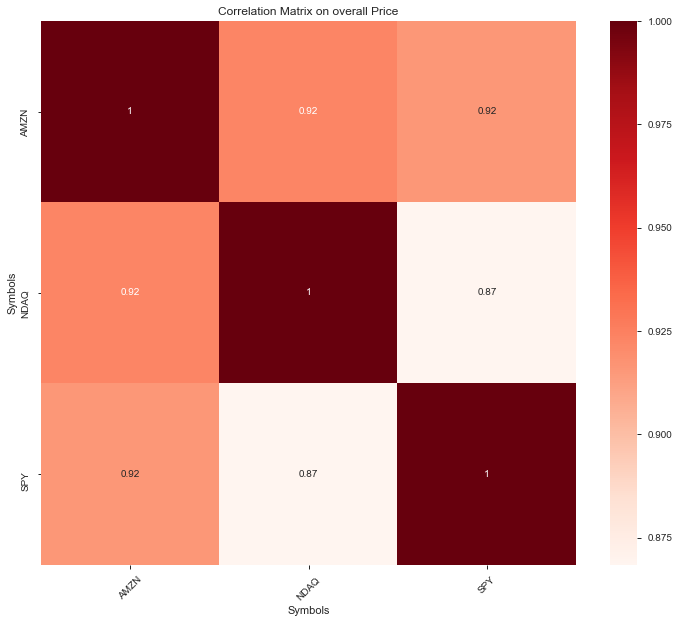

Covariance with SPY: 
Attributes           stock_return sp500_pct
Symbols                                    
Attributes   Symbols                       
stock_return             0.000347  0.000021
sp500_pct                0.000021  0.000068
Correlation Coefficent is 0.137
The P-value is 0.002, which is less than the significant level of 5%
The daily percentage change between targeted stock and SPY are strongly dependent with each other. They tend to move in the same direction
Target stock is more volatile than the market because of its higher standard deviation overall during this period


In [348]:
if __name__ == '__main__':

    #define input files
    stock_index = ['AMZN']
    
    # market index data 
    market_index =['NDAQ','SPY']
    
    
    # Parameters
    start_date ='2017-01-07'
    end_date='2018-12-30'
    rolling_window = 20
    
    #Create Data object
        
    stock_file = Data(stock_index,market_index,start_date,end_date)
    print('Header of stock data:')
    print(stock_file.stock_data.head())
    
    #Plotting data
    para_stock = Plotting(stock_file.stock_data,stock_index,market_index,rolling_window)
    

    
    
    
    
    
    